In [1]:
# Importing data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC


from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import warnings

# Suppress specific warning
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

In [2]:
# Loading three CSV files into pandas DataFrames
injury_data = pd.read_csv('InjuryRecord.csv')
play_data = pd.read_csv('PlayList.csv')
track_data = pd.read_csv('PlayerTrackData.csv')

In [3]:
# Merging Datasets: 
combined_data = pd.merge(play_data, track_data, on=['PlayKey'], how='inner')
# Adding a new column indicating weather or not an injury occured
combined_data['InjuryOccurred'] = combined_data['PlayKey'].isin(injury_data['PlayKey']).astype(int)

# Ensuring there is no NA data
combined_data = combined_data.dropna()

# Step 1: Split the data based on injury occurrence
injury_occurred = combined_data[combined_data['InjuryOccurred'] == 1]
no_injury_occurred = combined_data[combined_data['InjuryOccurred'] == 0]

no_injury_occurred = no_injury_occurred.dropna()

# Step 2: Sample data
# Take 100 rows where injury occurred
injury_sample = injury_occurred.sample(n=100, random_state=42)
# Take 100 rows where no injury occurred
no_injury_sample = no_injury_occurred.sample(n=100, random_state=42)

# Step 3: Combine the samples
final_sample = pd.concat([injury_sample, no_injury_sample])

# Step 4: Shuffle the final dataset to randomize the order
random_sampled_data = final_sample.sample(frac=1, random_state=42).reset_index(drop=True)

In [4]:
# Data Cleanup

# One-hot encoding for Weather data
weather_encoded = pd.get_dummies(random_sampled_data['Weather'], prefix='Weather')
# Combine the encoded columns with the original DataFrame
random_sampled_data = pd.concat([random_sampled_data, weather_encoded], axis=1)
# Drop the original 'Weather' column if no longer needed
random_sampled_data.drop(columns=['Weather'], inplace=True)

# Group definitions for weather categories
weather_groups = {
    'Sunny_Weather': [
        'Weather_Sunny', 'Weather_Sunny Skies', 'Weather_Sunny and clear',
        'Weather_Sunny and cold', 'Weather_Sunny and warm', 'Weather_Mostly sunny', 
        'Weather_Partly Sunny', 'Weather_Partly sunny', 
        'Weather_Sunny, Windy', 'Weather_Sunny, highs to upper 80s',  'Weather_Mostly Sunny', 'Weather_Mostly Sunny Skies'
    ],
    'Clear_Weather': [
        'Weather_Clear',
        'Weather_Clear Skies', 'Weather_Clear and Cool',
        'Weather_Clear and Sunny', 'Weather_Clear and cold',
        'Weather_Clear and sunny', 'Weather_Clear and warm',
        'Weather_Clear skies', 'Weather_Clear to Partly Cloudy', 'Weather_Partly clear'
    ],
    'Cloudy_Weather': [
        'Weather_Cloudy', 'Weather_Cloudy and Cool', 'Weather_Cloudy and cold',
        'Weather_Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
        'Weather_Cloudy, 50% change of rain', 'Weather_Cloudy, Rain',
        'Weather_Cloudy, chance of rain', 'Weather_cloudy', 'Weather_Overcast', 
        'Weather_Cloudy, fog started developing in 2nd quarter',
        'Weather_Cloudy, light snow accumulating 1-3"', 'Weather_Coudy',
        'Weather_Mostly Cloudy', 'Weather_Mostly Coudy', 'Weather_Mostly cloudy'
    ],
    'Low_Rain_Weather': [
        'Weather_10% Chance of Rain', 'Weather_30% Chance of Rain', 'Weather_Light Rain'
    ],
    'Rainy_Weather': [
        'Weather_Rain', 'Weather_Rain Chance 40%', 'Weather_Rain likely, temps in low 40s.',
        'Weather_Rain shower', 'Weather_Rainy', 'Weather_Scattered Showers',
        'Weather_Showers'
    ],
    'Indoor_Weather': [
        'Weather_Indoor', 'Weather_Indoors', 'Weather_Controlled Climate',
        'Weather_N/A (Indoors)', 'Weather_N/A Indoor'
    ],
    'Partly_Cloudy_Weather': [
        'Weather_Partly Cloudy', 'Weather_Partly Clouidy', 'Weather_Partly cloudy',
        'Weather_Party Cloudy', 'Weather_Sun & clouds'
    ],
    'Snowy_Weather': [
        'Weather_Snow', 'Weather_Heavy lake effect snow'
    ],
    'Other_Weather': [
        'Weather_Fair', 'Weather_Hazy', 'Weather_Heat Index 95'
    ]
}

for group_name, columns in weather_groups.items():
    # Check if the columns exist in the DataFrame
    columns_present = [col for col in columns if col in random_sampled_data.columns]
    # Combine the columns
    random_sampled_data[group_name] = random_sampled_data[columns_present].max(axis=1)
    # Optionally drop the old columns
    random_sampled_data.drop(columns=columns_present, inplace=True)

field_type_encoded = pd.get_dummies(random_sampled_data['FieldType'], prefix='FieldType')
# Combine the encoded columns with the original DataFrame
random_sampled_data = pd.concat([random_sampled_data, field_type_encoded], axis=1)
# Drop the original 'FieldType' column if no longer needed
random_sampled_data.drop(columns=['FieldType'], inplace=True)

stadium_type_encoded = pd.get_dummies(random_sampled_data['StadiumType'], prefix='StadiumType')
# Combine the encoded columns with the original DataFrame
random_sampled_data = pd.concat([random_sampled_data, stadium_type_encoded], axis=1)
# Drop the original 'FieldType' column if no longer needed
random_sampled_data.drop(columns=['StadiumType'], inplace=True)

stadium_type_groups = {
    'Indoor_Stadium': [
        'StadiumType_Closed Dome', 'StadiumType_Dome', 'StadiumType_Dome, closed',
        'StadiumType_Domed', 'StadiumType_Indoor', 'StadiumType_Indoor, Open Roof',
        'StadiumType_Indoor, Roof Closed', 'StadiumType_Indoors'
    ],
    'Outdoor_Stadium': [
        'StadiumType_Bowl', 'StadiumType_Cloudy', 'StadiumType_Heinz Field',
        'StadiumType_Open', 'StadiumType_Oudoor', 'StadiumType_Ourdoor',
        'StadiumType_Outddors', 'StadiumType_Outdoor', 'StadiumType_Outdoors',
        'StadiumType_Outdor', 'StadiumType_Outside'
    ],
    'Retractable_Roof_Stadium': [
        'StadiumType_Domed, Open', 'StadiumType_Domed, open',
        'StadiumType_Outdoor Retr Roof-Open', 'StadiumType_Retr. Roof - Closed',
        'StadiumType_Retr. Roof - Open', 'StadiumType_Retr. Roof Closed', 'StadiumType_Domed, closed',
        'StadiumType_Retr. Roof-Closed', 'StadiumType_Retractable Roof', 'StadiumType_Retr. Roof-Open'
    ]
}
# Iterate through stadium type groups and combine columns
for group_name, columns in stadium_type_groups.items():
    # Check if the columns exist in the DataFrame
    columns_present = [col for col in columns if col in random_sampled_data.columns]
    # Combine the columns
    random_sampled_data[group_name] = random_sampled_data[columns_present].max(axis=1)
    # Optionally drop the old columns
    random_sampled_data.drop(columns=columns_present, inplace=True)

columns_of_interest  = [
    'Sunny_Weather', 'Clear_Weather', 'Cloudy_Weather', 'Low_Rain_Weather', 
    'Rainy_Weather', 'Indoor_Weather', 'Partly_Cloudy_Weather', 'Snowy_Weather', 
    'Other_Weather', 'FieldType_Natural', 'FieldType_Synthetic', 'Indoor_Stadium', 
    'Outdoor_Stadium', 'Retractable_Roof_Stadium']

for column in columns_of_interest:
    random_sampled_data[column] = random_sampled_data[column].replace({True: 1, False: 0})

columns_of_interest.append('Temperature')

/var/folders/1v/rphybfn151d42hnnhv4s72jm0000gn/T/ipykernel_73948/2097663629.py:113: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  random_sampled_data[column] = random_sampled_data[column].replace({True: 1, False: 0})


In [5]:

# Filter the DataFrame to use only the columns of interest
df_of_interest = random_sampled_data[columns_of_interest + ['InjuryOccurred']]  # Add 'InjuryOccurred' as target column

print(df_of_interest[columns_of_interest].info())
print(df_of_interest['InjuryOccurred'].unique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Sunny_Weather             200 non-null    int64  
 1   Clear_Weather             200 non-null    int64  
 2   Cloudy_Weather            200 non-null    int64  
 3   Low_Rain_Weather          200 non-null    int64  
 4   Rainy_Weather             200 non-null    int64  
 5   Indoor_Weather            200 non-null    int64  
 6   Partly_Cloudy_Weather     200 non-null    int64  
 7   Snowy_Weather             0 non-null      float64
 8   Other_Weather             0 non-null      float64
 9   FieldType_Natural         200 non-null    int64  
 10  FieldType_Synthetic       200 non-null    int64  
 11  Indoor_Stadium            200 non-null    int64  
 12  Outdoor_Stadium           200 non-null    int64  
 13  Retractable_Roof_Stadium  200 non-null    int64  
 14  Temperatur

In [6]:

# Removing Snowy_Weather and Other_Weather columns as they are null
random_sampled_data = random_sampled_data.drop(columns=['Snowy_Weather', 'Other_Weather'])
columns_of_interest  = [
    'Sunny_Weather', 'Clear_Weather', 'Cloudy_Weather', 'Low_Rain_Weather', 
    'Rainy_Weather', 'Indoor_Weather', 'Partly_Cloudy_Weather',  'FieldType_Natural', 
    'FieldType_Synthetic', 'Indoor_Stadium', 'Outdoor_Stadium', 'Retractable_Roof_Stadium', 
    'Temperature']

print(df_of_interest[columns_of_interest].info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Sunny_Weather             200 non-null    int64
 1   Clear_Weather             200 non-null    int64
 2   Cloudy_Weather            200 non-null    int64
 3   Low_Rain_Weather          200 non-null    int64
 4   Rainy_Weather             200 non-null    int64
 5   Indoor_Weather            200 non-null    int64
 6   Partly_Cloudy_Weather     200 non-null    int64
 7   FieldType_Natural         200 non-null    int64
 8   FieldType_Synthetic       200 non-null    int64
 9   Indoor_Stadium            200 non-null    int64
 10  Outdoor_Stadium           200 non-null    int64
 11  Retractable_Roof_Stadium  200 non-null    int64
 12  Temperature               200 non-null    int64
dtypes: int64(13)
memory usage: 20.4 KB
None


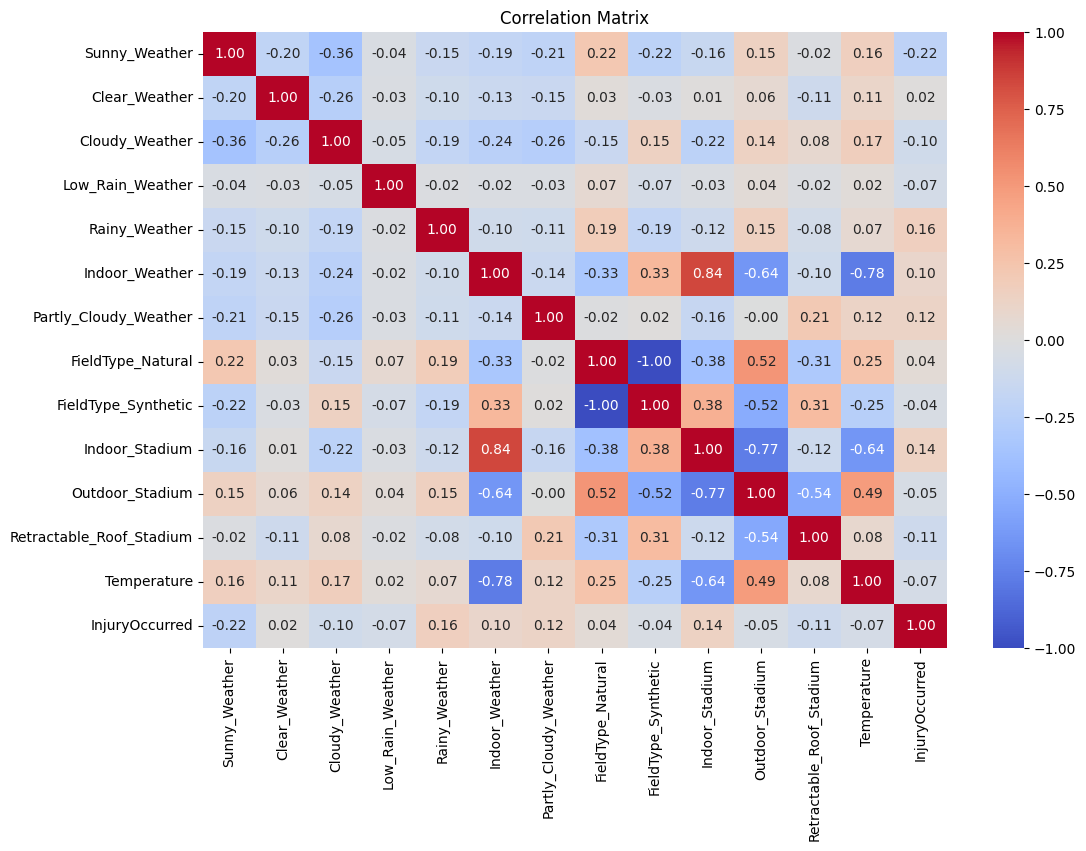

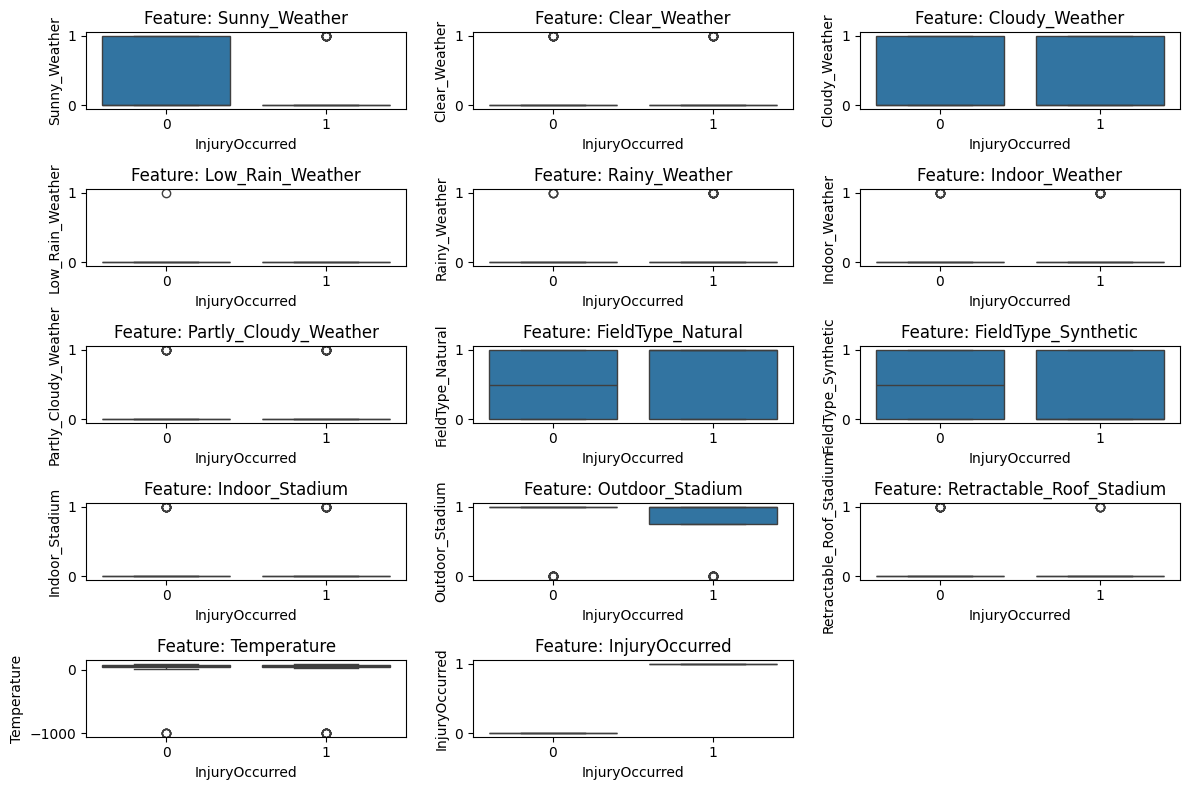

In [7]:
# Separate numerical and categorical columns from columns_of_interest
df_of_interest = random_sampled_data[columns_of_interest + ['InjuryOccurred']]

numerical_features = df_of_interest.select_dtypes(include=['float64', 'int64'])  # Numerical columns
categorical_features = df_of_interest.select_dtypes(include=['object', 'category'])  # Categorical columns

# Correlation Matrix for Numerical Features
if not numerical_features.empty:  # Ensure there are numerical features to plot
    correlation_matrix = numerical_features.corr()
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.show()

# Box Plots for Numerical Features vs Injury Occurrence
if not numerical_features.empty:  # Ensure there are numerical features to plot
    plt.figure(figsize=(12, 8))
    num_plots = len(numerical_features.columns)
    rows = (num_plots // 3) + (1 if num_plots % 3 != 0 else 0)  # Calculate number of rows needed

    for i, col in enumerate(numerical_features.columns):
        plt.subplot(rows, 3, i + 1)  # Adjust rows and columns dynamically
        sns.boxplot(x='InjuryOccurred', y=col, data=df_of_interest)
        plt.title(f'Feature: {col}')
    
    plt.tight_layout()
    plt.show()

# Bar Plots for Categorical Features vs Injury Occurrence
if not categorical_features.empty:  # Ensure there are categorical features to plot
    plt.figure(figsize=(12, 8))
    num_plots = len(categorical_features.columns)
    rows = (num_plots // 3) + (1 if num_plots % 3 != 0 else 0)  # Calculate number of rows needed

    for i, col in enumerate(categorical_features.columns):
        plt.subplot(rows, 3, i + 1)  # Adjust rows and columns dynamically
        sns.countplot(x=col, hue='InjuryOccurred', data=df_of_interest, palette='pastel')
        plt.title(f'Feature: {col}')
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    
    plt.tight_layout()
    plt.show()


In [8]:
# Update columns of interest
columns_of_interest = ['Cloudy_Weather', 'Sunny_Weather', 'FieldType_Natural', 
       'Outdoor_Stadium', 'Temperature', 'Indoor_Stadium', 'Indoor_Weather']

# Apply the replacement for each column
for column in columns_of_interest:
    random_sampled_data[column] = random_sampled_data[column].apply(lambda x: 1 if x == True else 0)

X = random_sampled_data[columns_of_interest].fillna(0)
y = random_sampled_data['InjuryOccurred'].fillna(0)

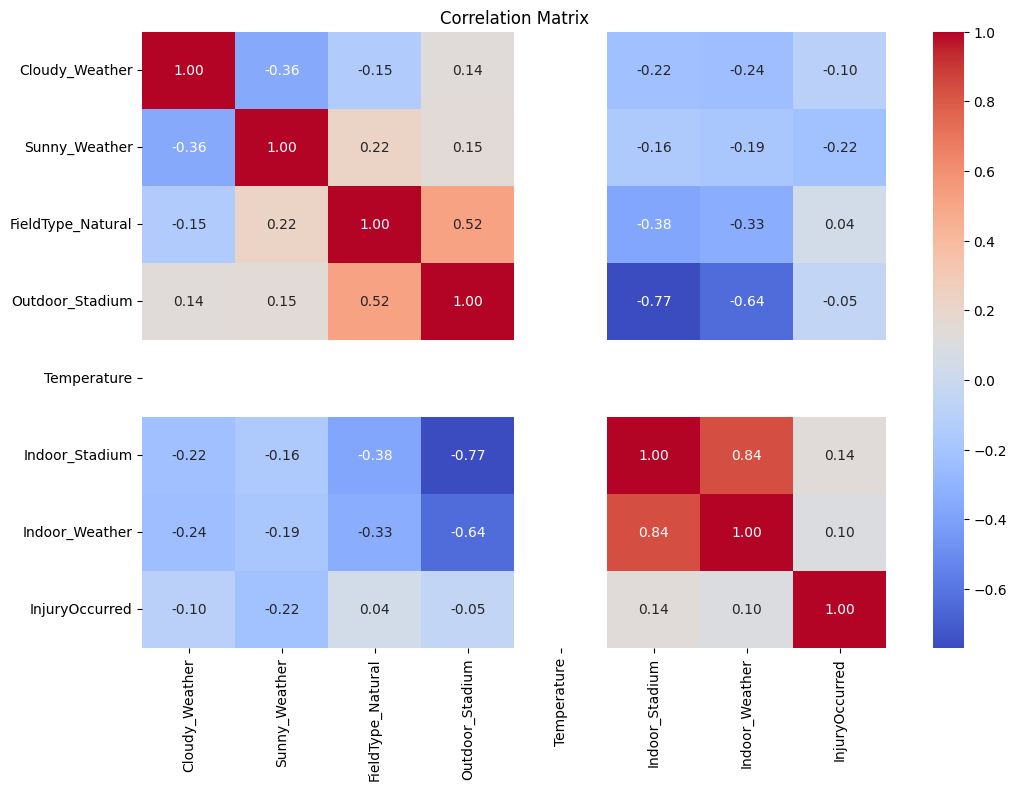

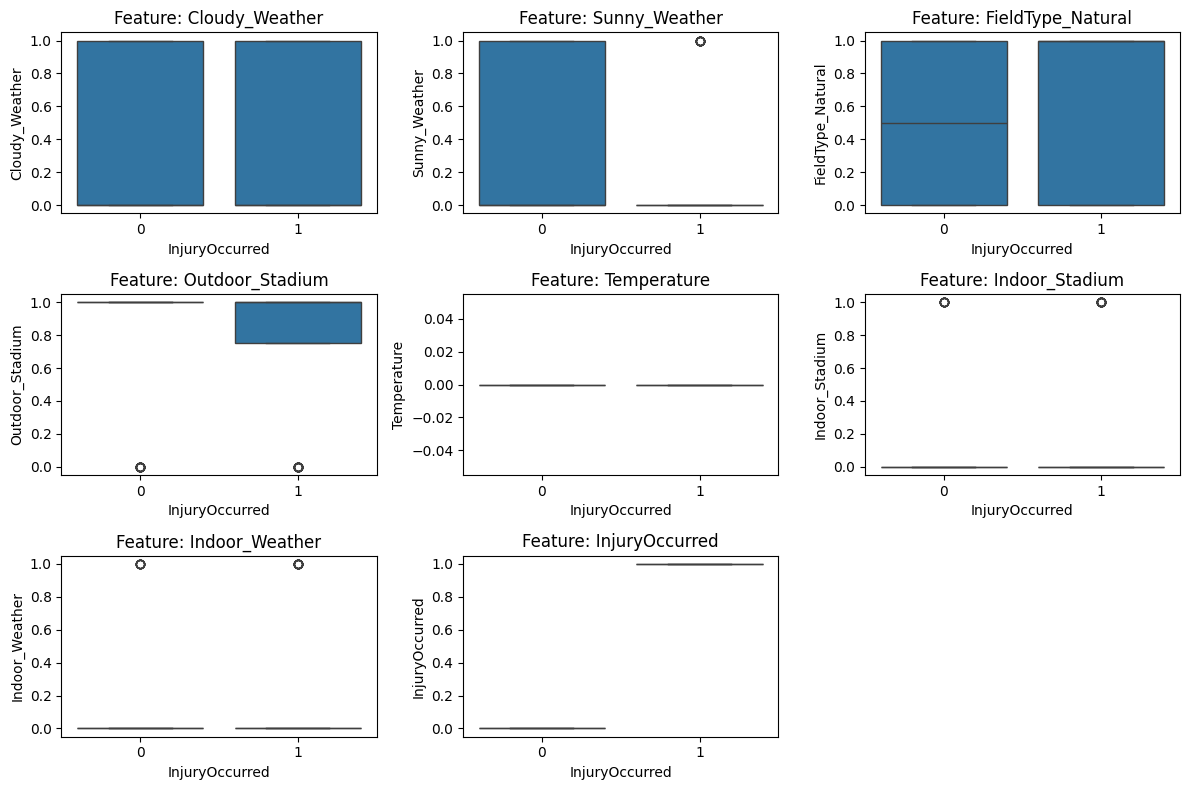

<Figure size 1200x800 with 0 Axes>

In [9]:
# Filter the DataFrame to use only the columns of interest
df_of_interest = random_sampled_data[columns_of_interest + ['InjuryOccurred']]  # Add 'InjuryOccurred' as target column

# Separate numerical and categorical columns from columns_of_interest
numerical_features = df_of_interest.select_dtypes(include=['float64', 'int64'])  # Numerical columns
categorical_features = df_of_interest.select_dtypes(include=['object'])  # Categorical columns

# Correlation Matrix for Numerical Features
correlation_matrix = numerical_features.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Box Plots for Numerical Features vs Injury Occurrence
plt.figure(figsize=(12, 8))
num_plots = len(numerical_features.columns)
rows = (num_plots // 3) + (1 if num_plots % 3 != 0 else 0)  # Calculate number of rows needed

for i, col in enumerate(numerical_features.columns):
    plt.subplot(rows, 3, i + 1)  # Adjust rows and columns dynamically
    sns.boxplot(x='InjuryOccurred', y=col, data=df_of_interest)
    plt.title(f'Feature: {col}')
    
plt.tight_layout()
plt.show()

# Bar Plots for Categorical Features vs Injury Occurrence
plt.figure(figsize=(12, 8))
for i, col in enumerate(categorical_features.columns):
    plt.subplot(2, 3, i + 1)
    sns.countplot(x=col, hue='InjuryOccurred', data=df_of_interest)
    plt.title(f'Feature: {col}')
    
plt.tight_layout()
plt.show()


In [10]:
# Populating Training and Testing data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

For Random Forest Classifier               precision    recall  f1-score   support

           0       0.56      0.50      0.53        18
           1       0.62      0.68      0.65        22

    accuracy                           0.60        40
   macro avg       0.59      0.59      0.59        40
weighted avg       0.60      0.60      0.60        40



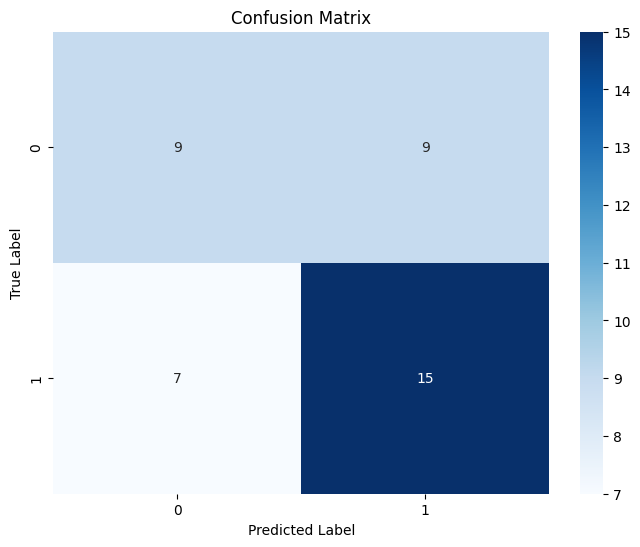

In [11]:
# Creating model for Random Forest

model = RandomForestClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("For Random Forest Classifier",classification_report(y_test, predictions))

cm = confusion_matrix(y_test, predictions)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

              precision    recall  f1-score   support

           0       0.53      0.50      0.51        18
           1       0.61      0.64      0.62        22

    accuracy                           0.57        40
   macro avg       0.57      0.57      0.57        40
weighted avg       0.57      0.57      0.57        40



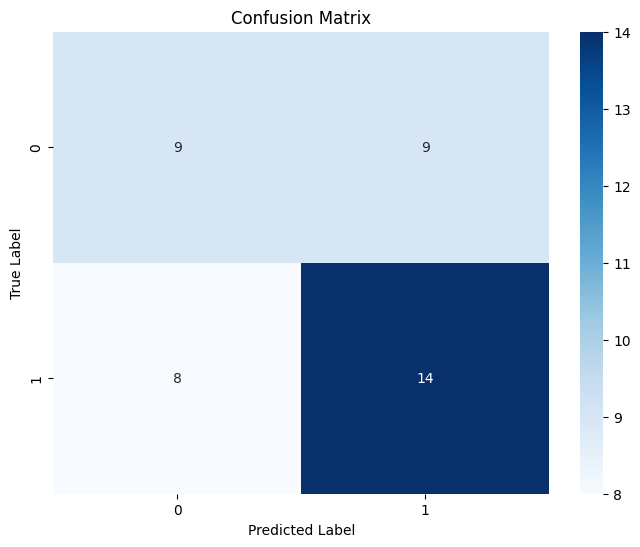

In [12]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

cm = confusion_matrix(y_test, predictions)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

              precision    recall  f1-score   support

           0       0.61      0.61      0.61        18
           1       0.68      0.68      0.68        22

    accuracy                           0.65        40
   macro avg       0.65      0.65      0.65        40
weighted avg       0.65      0.65      0.65        40



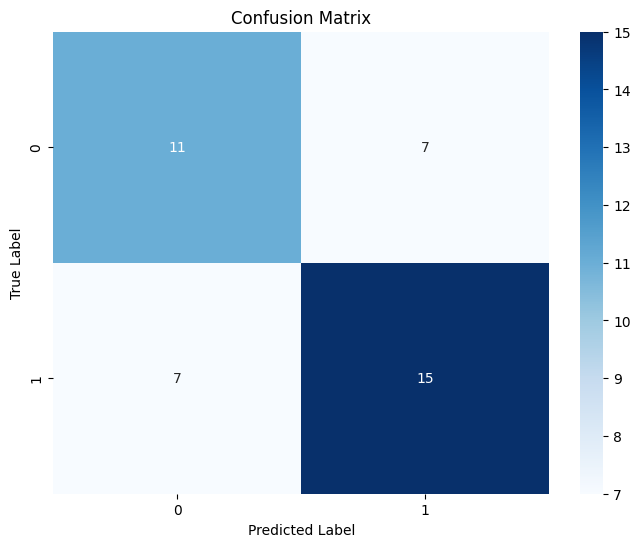

In [13]:
svm_model = SVC(kernel='rbf', random_state=42, max_iter=10000)  # Radial basis function kernel is commonly used for non-linear classification
svm_model.fit(X_train, y_train)
predictions = svm_model.predict(X_test)

print(classification_report(y_test, predictions))

cm = confusion_matrix(y_test, predictions)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [14]:
def build_model(num_layers=5, neurons=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=X_train.shape[1]))
    for _ in range(num_layers):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter tuning
num_layers = 9
neurons = 128
dropout_rate = 0.4
learning_rate = 0.001
batch_size = 72
# Build and train the model
model = build_model(num_layers=num_layers, neurons=neurons, dropout_rate=dropout_rate, learning_rate=learning_rate)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=batch_size, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test loss: {test_loss:.2f}")


# Print the accuracy scores for each fold and the average 

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.4711 - loss: 0.6953 - val_accuracy: 0.6875 - val_loss: 0.6926
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4797 - loss: 0.6937 - val_accuracy: 0.5312 - val_loss: 0.6928
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4462 - loss: 0.6999 - val_accuracy: 0.4688 - val_loss: 0.6933
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4959 - loss: 0.6905 - val_accuracy: 0.3750 - val_loss: 0.6940
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5098 - loss: 0.6954 - val_accuracy: 0.3750 - val_loss: 0.6947
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5399 - loss: 0.6933 - val_accuracy: 0.3750 - val_loss: 0.6949
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6146 - loss: 0.6928
Test Accuracy: 0.62
Test loss: 0.69


In [15]:

param_grid = {
    'num_layers': [3, 5, 7, 9],
    'neurons': [64, 128],
    'dropout_rate': [0.2, 0.3, 0.4],
    'learning_rate': [0.001],
    'batch_size': [32, 64, 72, 128]
}

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Initialize best metrics
best_accuracy = 0
best_loss = 2
best_params = {}
best_score = 0

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Iterate over all combinations of hyperparameters
for num_layers in param_grid['num_layers']:
    for neurons in param_grid['neurons']:
        for dropout_rate in param_grid['dropout_rate']:
            for learning_rate in param_grid['learning_rate']:
                for batch_size in param_grid['batch_size']:
                    # Build and train the model
                    model = build_model(num_layers=num_layers, neurons=neurons, dropout_rate=dropout_rate, learning_rate=learning_rate)
                    
                    # Train the model with the current hyperparameters
                    history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=batch_size, callbacks=[early_stopping], verbose=0)
                    
                    # Evaluate the model
                    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
                    if test_loss < 0.7 and test_accuracy> 0.5:
                        print(f"Evaluating model with params: num_layers={num_layers}, neurons={neurons}, "
                            f"dropout_rate={dropout_rate}, learning_rate={learning_rate}, batch_size={batch_size}")
                        print(f"Test Accuracy: {test_accuracy:.2f}, Test Loss: {test_loss:.2f}")
                    
                    score = test_accuracy - (test_loss * 0.5)  # You can adjust the weight factor
                    # Update the best parameters based on the score
                    if score > best_score:
                        best_score = score
                        best_accuracy = test_accuracy
                        best_loss = test_loss
                        best_params = {
                            'num_layers': num_layers,
                            'neurons': neurons,
                            'dropout_rate': dropout_rate,
                            'learning_rate': learning_rate,
                            'batch_size': batch_size
                        }

# Output the best combination of hyperparameters
print("\nBest Model Parameters:")
print(f"Test Accuracy: {best_accuracy:.2f}")
print(f"Test Loss: {best_loss:.2f}")
print(f"Best Hyperparameters: {best_params}")

Evaluating model with params: num_layers=3, neurons=64, dropout_rate=0.2, learning_rate=0.001, batch_size=32
Test Accuracy: 0.60, Test Loss: 0.69
Evaluating model with params: num_layers=3, neurons=64, dropout_rate=0.2, learning_rate=0.001, batch_size=64
Test Accuracy: 0.57, Test Loss: 0.69
Evaluating model with params: num_layers=3, neurons=64, dropout_rate=0.2, learning_rate=0.001, batch_size=128
Test Accuracy: 0.57, Test Loss: 0.69
Evaluating model with params: num_layers=3, neurons=64, dropout_rate=0.3, learning_rate=0.001, batch_size=64
Test Accuracy: 0.52, Test Loss: 0.70
Evaluating model with params: num_layers=3, neurons=64, dropout_rate=0.3, learning_rate=0.001, batch_size=72
Test Accuracy: 0.57, Test Loss: 0.69
Evaluating model with params: num_layers=3, neurons=64, dropout_rate=0.3, learning_rate=0.001, batch_size=128
Test Accuracy: 0.52, Test Loss: 0.69
Evaluating model with params: num_layers=3, neurons=64, dropout_rate=0.4, learning_rate=0.001, batch_size=32
Test Accuracy